
# Face classification using Haar-like feature descriptor

Haar-like feature descriptors were successfully used to implement the first
real-time face detector [1]_. Inspired by this application, we propose an
example illustrating the extraction, selection, and classification of Haar-like
features to detect faces vs. non-faces.

## Notes

This example relies on [scikit-learn](https://scikit-learn.org/) for feature
selection and classification.

## References

.. [1] Viola, Paul, and Michael J. Jones. "Robust real-time face
       detection." International journal of computer vision 57.2
       (2004): 137-154.
       https://www.merl.com/publications/docs/TR2004-043.pdf
       :DOI:`10.1109/CVPR.2001.990517`


In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

The procedure to extract the Haar-like features from an image is relatively
simple. Firstly, a region of interest (ROI) is defined. Secondly, the
integral image within this ROI is computed. Finally, the integral image is
used to extract the features.



In [2]:
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

We use a subset of CBCL dataset which is composed of 100 face images and
100 non-face images. Each image has been resized to a ROI of 19 by 19
pixels. We select 75 images from each group to train a classifier and
determine the most salient features. The remaining 25 images from each
class are used to assess the performance of the classifier.



In [3]:
images = lfw_subset()
# To speed up the example, extract the two types of features only
feature_types = ['type-2-x', 'type-2-y']

# Compute the result
t_start = time()
X = [extract_feature_image(img, feature_types) for img in images]
X = np.stack(X)
time_full_feature_comp = time() - t_start

# Label images (100 faces and 100 non-faces)
y = np.array([1] * 100 + [0] * 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

# Extract all possible features
feature_coord, feature_type = \
    haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                            feature_type=feature_types)

A random forest classifier can be trained in order to select the most
salient features, specifically for face classification. The idea is to
determine which features are most often used by the ensemble of trees.
By using only the most salient features in subsequent steps, we can
drastically speed up the computation while retaining accuracy.



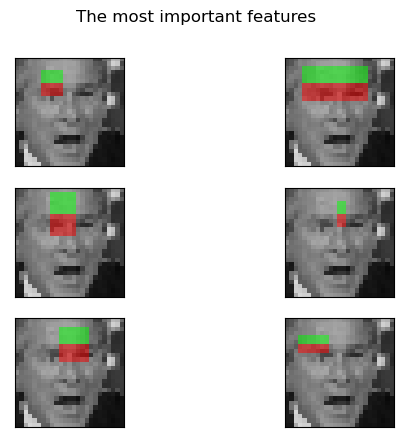

In [4]:
# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

We can select the most important features by checking the cumulative sum
of the feature importance. In this example, we keep the features
representing 70% of the cumulative value (which corresponds to using only 3%
of the total number of features).



In [5]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= cdf_feature_importances[-1]  # divide by max value
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print(f'{sig_feature_count} features, or {sig_feature_percent}%, '
       f'account for 70% of branch points in the random forest.')

# Select the determined number of most informative features
feature_coord_sel = feature_coord[idx_sorted[:sig_feature_count]]
feature_type_sel = feature_type[idx_sorted[:sig_feature_count]]
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

# Compute the result
t_start = time()
X = [
    extract_feature_image(img, feature_type_sel, feature_coord_sel)
    for img in images
]
X = np.stack(X)
time_subs_feature_comp = time() - t_start

y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

712 features, or 0.7%, account for 70% of branch points in the random forest.


Once the features are extracted, we can train and test a new classifier.



In [6]:
t_start = time()
clf.fit(X_train, y_train)
time_subs_train = time() - t_start

auc_subs_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

summary = (f'Computing the full feature set took '
            f'{time_full_feature_comp:.3f}s, '
            f'plus {time_full_train:.3f}s training, '
            f'for an AUC of {auc_full_features:.2f}. '
            f'Computing the restricted feature set took '
            f'{time_subs_feature_comp:.3f}s, plus {time_subs_train:.3f}s '
            f'training, for an AUC of {auc_subs_features:.2f}.')

print(summary)
plt.show()

Computing the full feature set took 21.910s, plus 2.078s training, for an AUC of 1.00. Computing the restricted feature set took 0.067s, plus 1.788s training, for an AUC of 1.00.
